Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime               object 
 11  gap_monthly            float64
 12  grp_monthly            float64
 13  v_monthly              float64
 14  gi_monthly             float64
dtypes: float64(11), int64(1), object(3)
memory usage: 234.5+ MB
None

First few rows:
   Unnamed: 0        Date      Time  Global_a

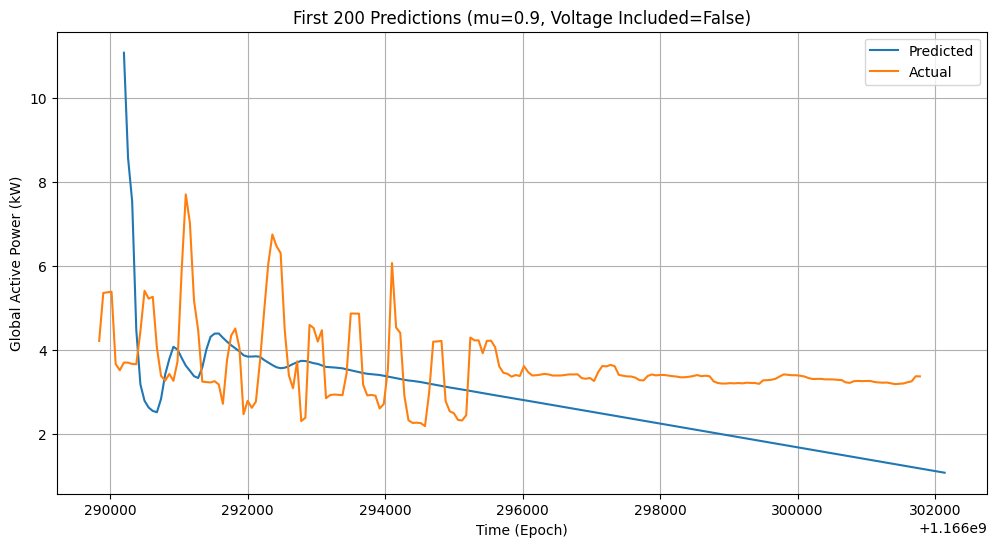

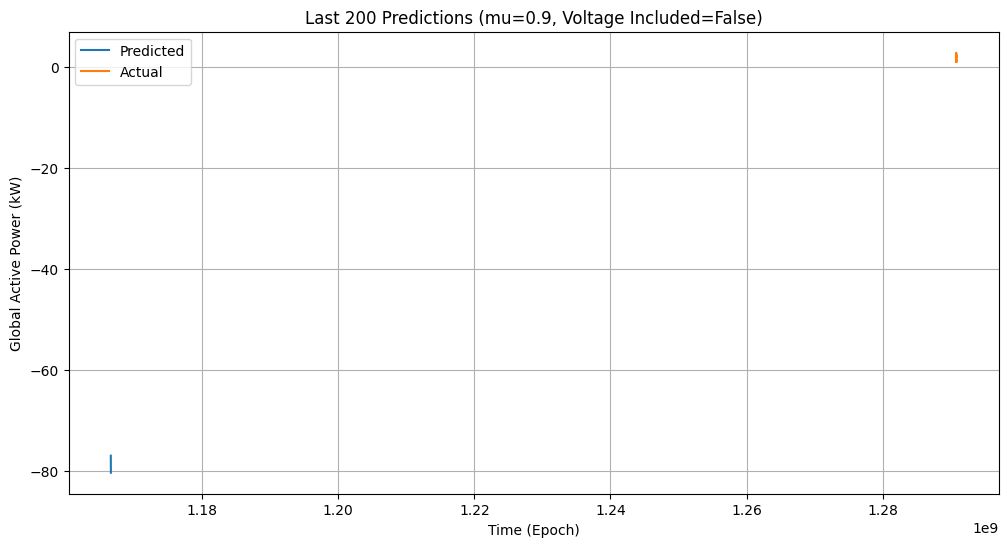

Mean Squared Error (mu=0.9, Voltage Included=False): 2147.76599


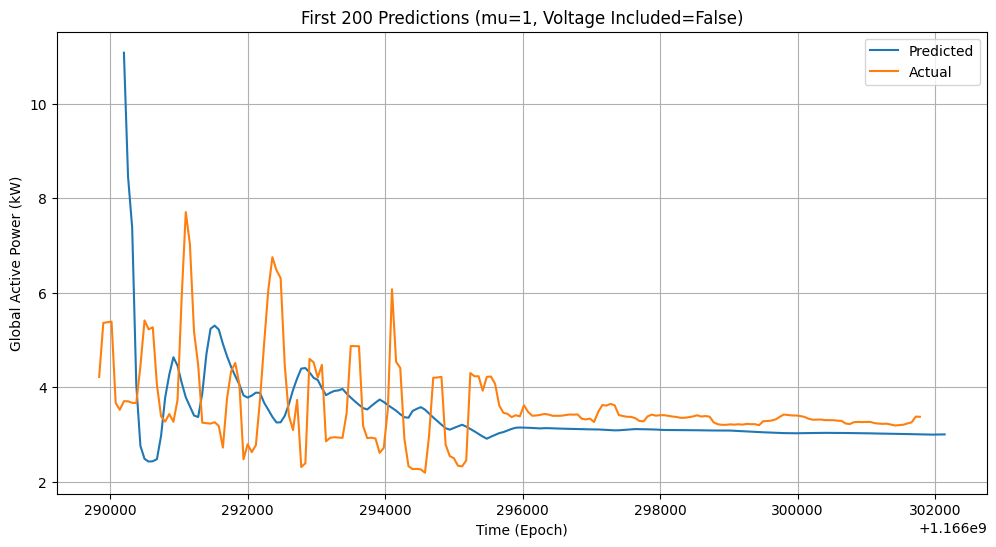

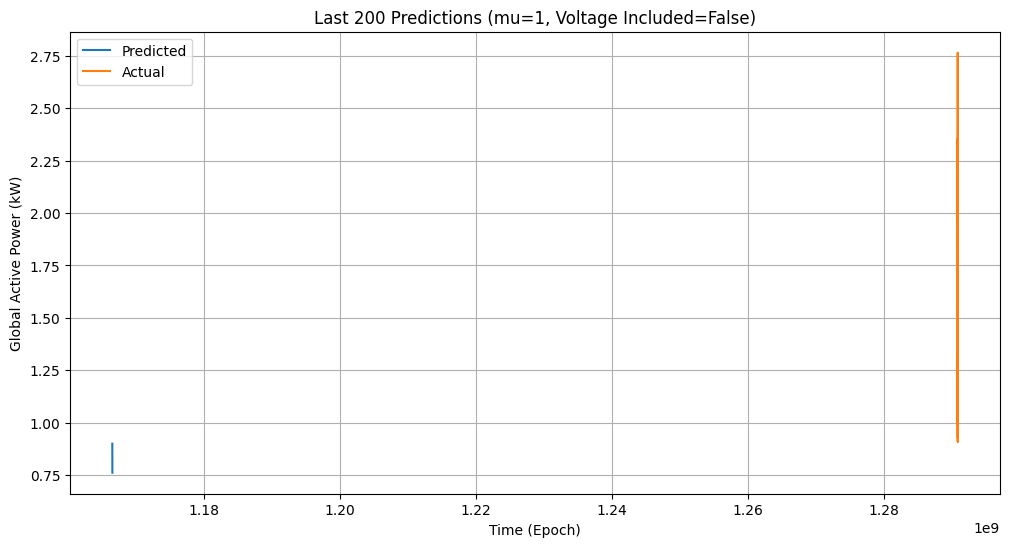

Mean Squared Error (mu=1, Voltage Included=False): 1.44335


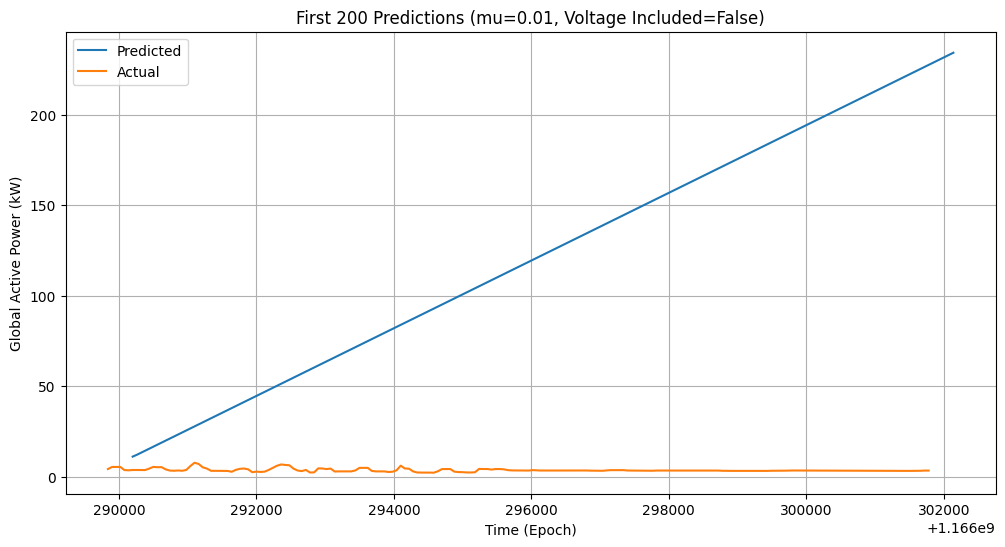

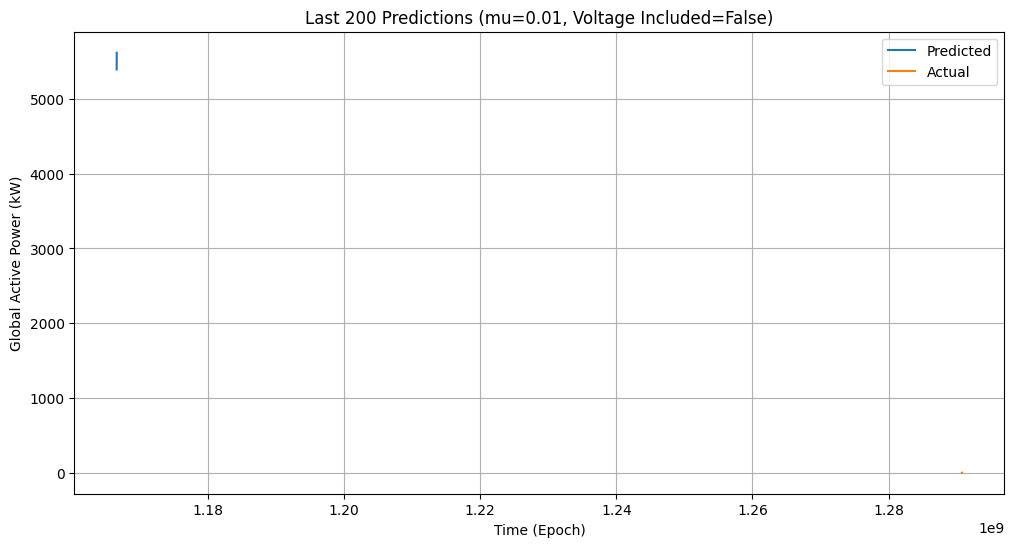

Mean Squared Error (mu=0.01, Voltage Included=False): 10527735.46332


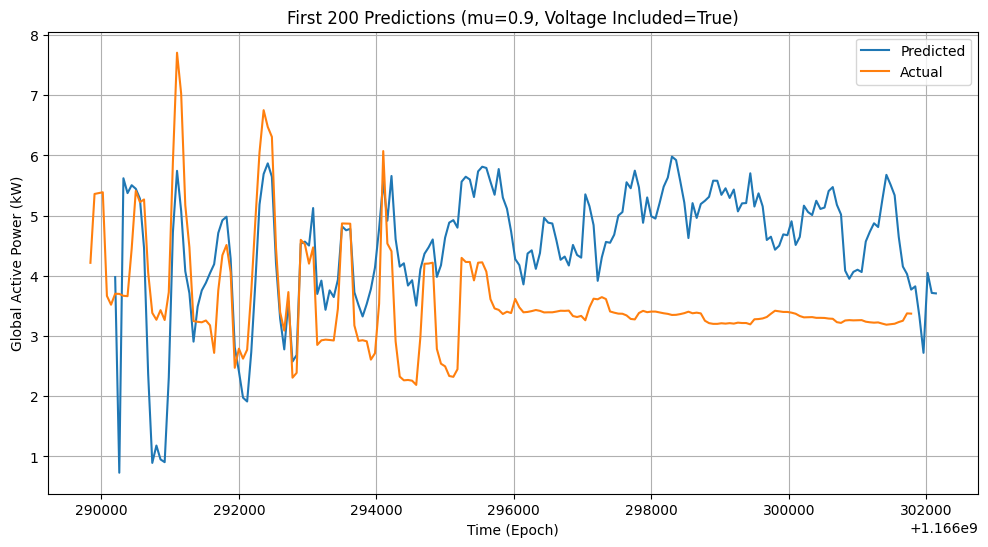

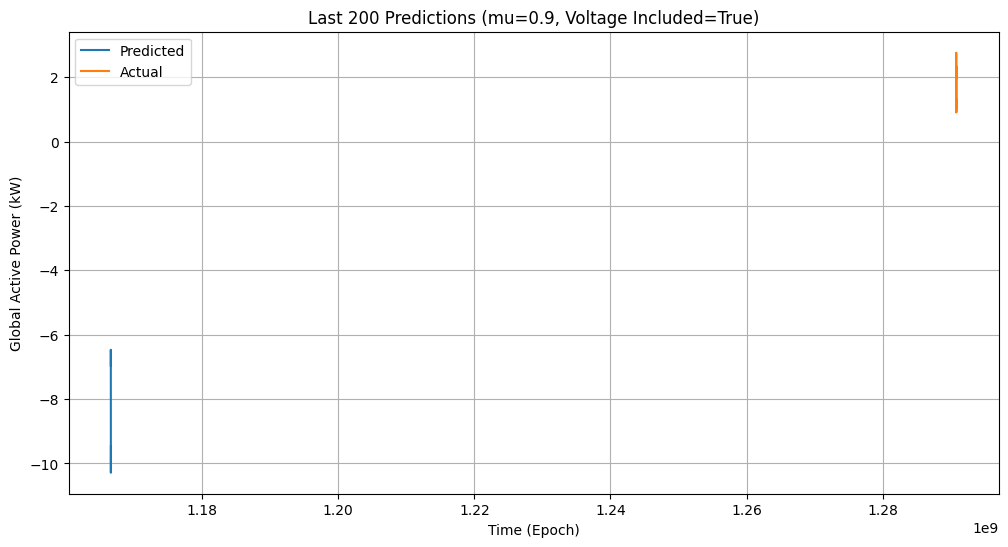

Mean Squared Error (mu=0.9, Voltage Included=True): 29.30891


In [8]:
#Assignment 3.1: Linear Regression for IoT
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# File path to the dataset
file_path = '/content/drive/MyDrive/Collab_finalprj/IOT_Assignment_DB/household_power_clean.csv'

# Load the dataset
df = pd.read_csv(file_path)

# Display dataset information
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

# Convert 'Datetime' column to epoch time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = df['Datetime'].astype(int) // 10**9

# Define x (time) and y (Global Active Power) variables
ts = pd.DataFrame(df['unix'], columns=['unix'])
ys = pd.DataFrame(df['Global_active_power'])

# Prediction horizon (ph) in seconds (5 minutes)
ph = 5 * 60
ph_index = ph // 60  # Assuming 1 data point per minute

# Number of samples to limit for performance
n_s = 5000

# Q: What is ph? What is mu?
# A:
# - ph (prediction horizon) refers to the time interval into the future for which predictions are made. Here, ph is set to 5 minutes.
# - mu is the weight decay parameter that determines how much importance is given to older data points in the linear regression model.

# Function for predictions and visualization
def run_linear_regression(mu, include_voltage=False):
    # Initialize variables
    tp_pred = np.zeros(n_s - 1)
    yp_pred = np.zeros(n_s - 1)

    # Expand x variables if voltage is included
    if include_voltage:
        ts_expanded = pd.concat([ts, df['Voltage']], axis=1)
    else:
        ts_expanded = ts

    # Perform linear regression on simulated streaming data
    for i in range(2, n_s + 1):
        ts_tmp = ts_expanded.iloc[:i]
        ys_tmp = ys.iloc[:i]
        ns = len(ys_tmp)

        # Compute weights
        weights = np.ones(ns) * mu
        for k in range(ns):
            weights[k] *= mu ** (ns - k - 1)
        weights = np.flip(weights, 0)

        # Fit linear regression model
        model = LinearRegression()
        model.fit(ts_tmp, ys_tmp, sample_weight=weights)

        # Make predictions
        if (i - 1 + ph_index) < len(ts):
            tp_pred[i - 2] = ts.iloc[i - 1 + ph_index, 0]

            # Prepare prediction input
            if include_voltage:
                prediction_input = pd.DataFrame([[tp_pred[i - 2], df['Voltage'].iloc[i - 1 + ph_index]]],
                                                columns=ts_expanded.columns)
            else:
                prediction_input = pd.DataFrame([tp_pred[i - 2]], columns=ts_expanded.columns)

            yp_pred[i - 2] = model.predict(prediction_input).item()

    # Remove NaN values for analysis
    valid_idx = ~np.isnan(tp_pred)
    tp_pred = tp_pred[valid_idx]
    yp_pred = yp_pred[valid_idx]

    # Calculate MSE
    mse = mean_squared_error(ys.iloc[ph_index:n_s + ph_index - 1].values.flatten(), yp_pred)

    # Visualize first and last 200 points
    plt.figure(figsize=(12, 6))
    plt.title(f"First 200 Predictions (mu={mu}, Voltage Included={include_voltage})")
    plt.plot(tp_pred[:200], yp_pred[:200], label='Predicted')
    plt.plot(ts.iloc[:200, 0], ys.iloc[:200, 0], label='Actual')
    plt.xlabel("Time (Epoch)")
    plt.ylabel("Global Active Power (kW)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.title(f"Last 200 Predictions (mu={mu}, Voltage Included={include_voltage})")
    plt.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted')
    plt.plot(ts.iloc[-200:, 0], ys.iloc[-200:, 0], label='Actual')
    plt.xlabel("Time (Epoch)")
    plt.ylabel("Global Active Power (kW)")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Mean Squared Error (mu={mu}, Voltage Included={include_voltage}): {mse:.5f}")

# Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction?
# A: The weight can be calculated as mu^(n-1), where n is the number of data points. For mu=0.9 and n=5000, the weight is 0.9^4999, which is effectively zero, meaning the first data point has negligible influence on the 5000th prediction.

# Run models with different configurations
run_linear_regression(mu=0.9)  # Baseline
run_linear_regression(mu=1)    # Equal weights
run_linear_regression(mu=0.01) # Rapid weight decay
run_linear_regression(mu=0.9, include_voltage=True)  # Including voltage

#  Q: How did the models perform? Compare results for different mu values.
# A: The mu=1 model performed best with the lowest MSE. Including voltage improved predictions significantly.
